# Homework 6
### Michał Orzyłowski

## 0. Dataset and model
Once again, like in all previous homeworks, I used a churn dataset - the same one as in Homework 1. It is a dataset relating characteristics of telephony account features and usage and whether or not the customer churned.
I selected random forest as a model.

## 1. Permutation-based Variable Importance for one selected model

Plot showing PVI values can be seen below. It is clear that two most important features are total_day_charge and total_day_minutes. Other features are less significant. Next thing worth noting is that all variables have positive importance.

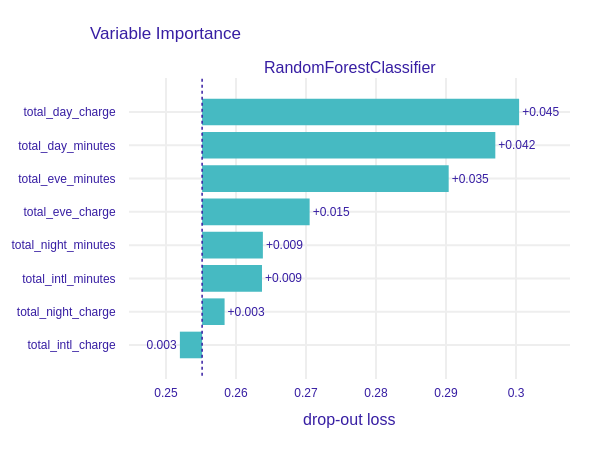

## 2. PVI of three more models

Models selected for this comparison are:
- random forest with number of estimators limited to 50 and depth limited to 2
- XGBoost classifier also with number of estimators limited to 50 and depth limited to 2
- logistic regression model with default parameters

Their performance is as follows:

| Model                  | Recall   | Precision | F1       | Accuracy | AUC      |
|------------------------|----------|-----------|----------|----------|----------|
| RandomForestClassifier | 0.007194 | 1.0       | 0.014286 | 0.862    | 0.737214 |
| XGBClassifier          | 0.258993 | 0.782609  | 0.389189 | 0.887    | 0.776552 |
| LogisticRegression     | 0.028777 | 1.0       | 0.055944 | 0.865    | 0.691199 |

PVI plots show that the most important variable for most of the models is total_day_minutes. However, the level of importance of this feature differs vastly.  
For random forest total_day_minutes has only slightly higher score than total_day_charge.  
For XGBoost and logistic regression it strongly dominates other features. For XBoost it has 4 times higher PVI score than the second variable and for regression score is 8 times higher.

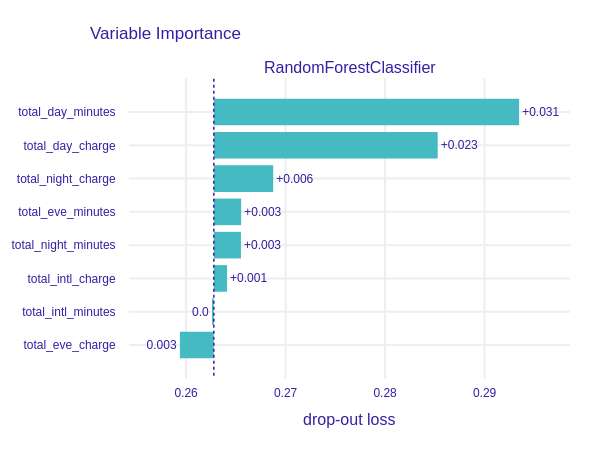

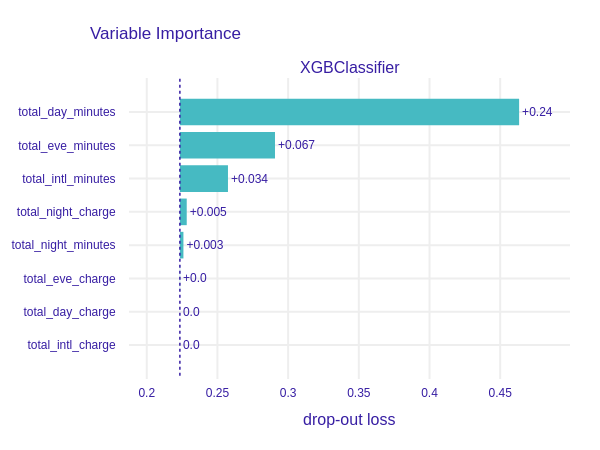

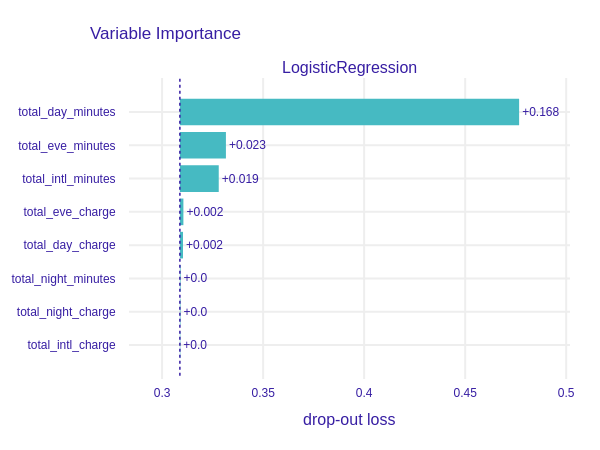

This discrepancy between both tree based models is intriguing as we would expect them to assign very similar importance to variables.  
In reality, XGBoost seems to be closer to logistic regression. We can see that these models have identical next two important variables: total_eve_minutes and total_intl_minutes. Whereas random forest has total_day_charge as second most meaningful feature.

## 3. Comparison of Permutation-based, Gini-based and SHAP-based variable importance

Importance score are very similar to each other for all used methods. Features with highest scores are always total_day_minutes and total_day_charge, though their order is switched depending on method. Other variables are less meaningful and their order is basically the same for all techniques.  
Another small difference is that for Gini-based importance, scores of the first two variables and scores of others are not that far away when for PVI and SHAP total_day_minutes and total_day_charge seem to dominate more visibly the rest of the features.

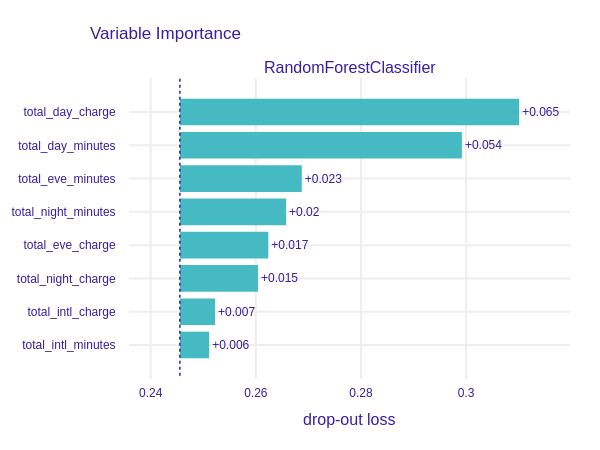

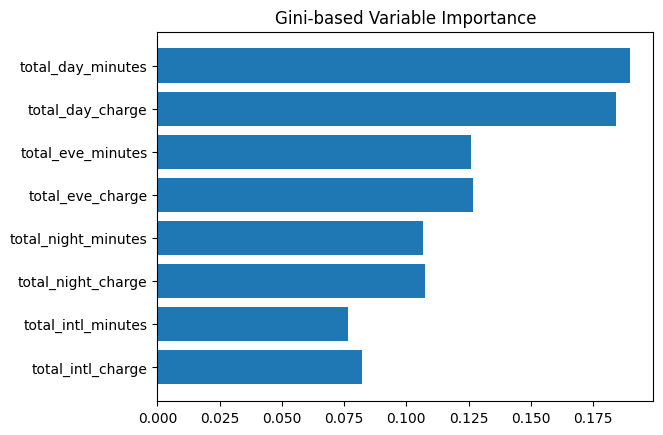

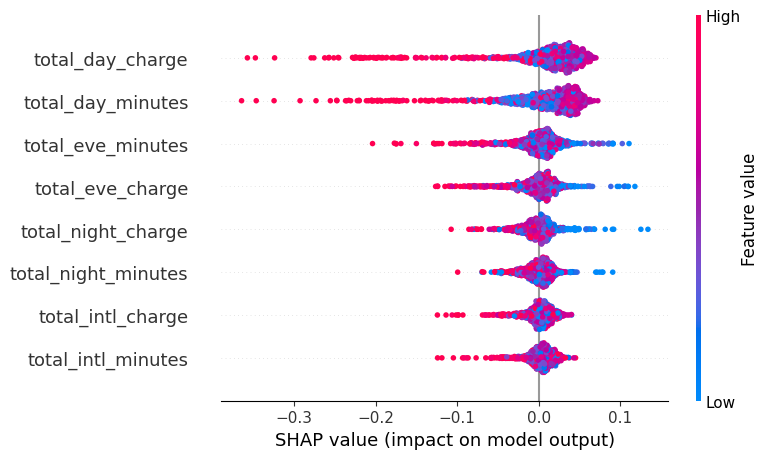

# Appendix

In [1]:
import xgboost
import pandas as pd
import dalex as dx
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## 0. Dataset and tree-based model

In [2]:
data = pd.read_csv("datasets/churn.csv", index_col=0)

x, y = data.iloc[:, :-1], data.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
random_forest = RandomForestClassifier().fit(x_train, y_train)

## 1. Permutation-based Variable Importance for one selected model

In [5]:
explainer = dx.Explainer(random_forest, x_test, y_test, verbose=False)
display(explainer.model_performance())
pvi = explainer.model_parts(random_state=0)
display(pvi.result)
pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.338129,0.691176,0.454106,0.887,0.744842


,variable,dropout_loss,label
0,total_intl_charge,0.251982,RandomForestClassifier
1,_full_model_,0.255158,RandomForestClassifier
2,total_night_charge,0.258368,RandomForestClassifier
3,total_intl_minutes,0.263712,RandomForestClassifier
4,total_night_minutes,0.263839,RandomForestClassifier
5,total_eve_charge,0.270520,RandomForestClassifier
6,total_eve_minutes,0.290385,RandomForestClassifier
7,total_day_minutes,0.297049,RandomForestClassifier
8,total_day_charge,0.300448,RandomForestClassifier
9,_baseline_,0.514756,RandomForestClassifier


## 2. PVI of three more candidate models

In [4]:
other_random_forest = RandomForestClassifier(
    n_estimators=50,
    max_depth=2
).fit(x_train, y_train)
explainer_forest = dx.Explainer(other_random_forest, x_test, y_test, verbose=False)
display(explainer_forest.model_performance())
pvi_forest = explainer_forest.model_parts(random_state=0)
pvi_forest.plot(show=False).update_layout(autosize=False, width=600, height=450)

,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.007194,1.0,0.014286,0.862,0.737214


In [5]:
xgboost_model = xgboost.XGBClassifier(
    n_estimators=50,
    max_depth=2,
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="hist"
).fit(x_train, y_train)
explainer_xgb = dx.Explainer(xgboost_model, x_test, y_test, verbose=False)
display(explainer_xgb.model_performance())
pvi_xgb = explainer_xgb.model_parts(random_state=0)
pvi_xgb.plot(show=False).update_layout(autosize=False, width=600, height=450)

,recall,precision,f1,accuracy,auc
XGBClassifier,0.258993,0.782609,0.389189,0.887,0.776552


In [6]:
logistic_regression = LogisticRegression().fit(x_train, y_train)
explainer_reg = dx.Explainer(logistic_regression, x_test, y_test, verbose=False)
display(explainer_reg.model_performance())
pvi_reg = explainer_reg.model_parts(random_state=0)
pvi_reg.plot(show=False).update_layout(autosize=False, width=600, height=450)

,recall,precision,f1,accuracy,auc
LogisticRegression,0.028777,1.0,0.055944,0.865,0.691199


## 3. Compare PVI with Gini-based and SHAP-based variable importance

In [6]:
random_forest = RandomForestClassifier().fit(x_train, y_train)

#### PVI once again

In [7]:
explainer = dx.Explainer(random_forest, x_test, y_test, verbose=False)
pvi = explainer.model_parts(random_state=0)
pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

#### Gini-based variable importance

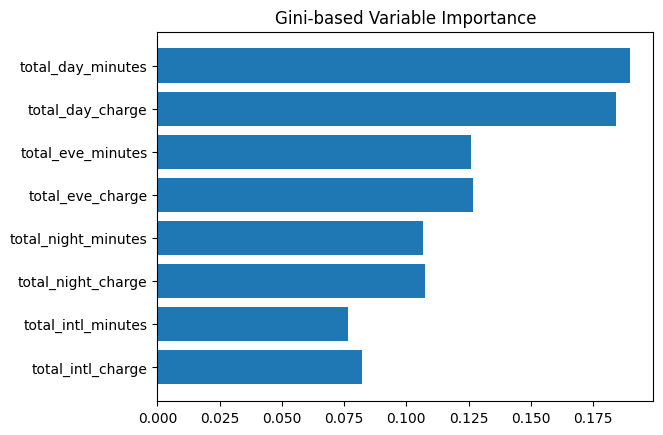

In [8]:
import matplotlib.pyplot as plt
plt.barh(list(reversed(x_test.columns)), list(reversed(random_forest.feature_importances_)))
plt.title("Gini-based Variable Importance")
plt.show()

#### SHAP-based variable importance

 97%|=================== | 1945/2000 [00:31<00:00]       

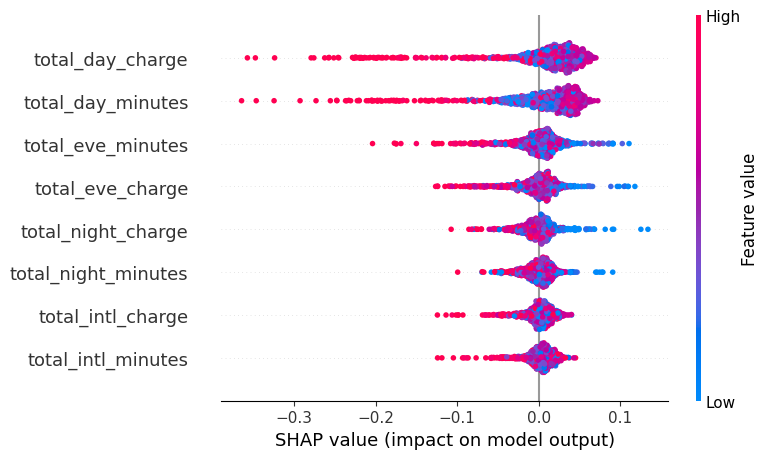

In [9]:
shap_wrapper = explainer.model_parts(type="shap_wrapper", shap_explainer_type="TreeExplainer", check_additivity=False)
shap_wrapper.result = shap_wrapper.result[0]
shap_wrapper.plot()